In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle

from simulations import *
from utils import *
from plot import *
from graspy.simulations import sbm
from mgcpy.independence_tests.mgc.mgc import MGC

from tqdm import tqdm_notebook as tqdm

In [2]:
with open('../data/rho_SBM_pvalue_mgc_null.pkl', 'rb') as f:
    pvalue_sbm_null = pickle.load(f)
with open('../data/rho_SBM_pvalue_mgc_alt.pkl', 'rb') as f:
    pvalue_sbm_alt = pickle.load(f)
with open('../data/rho_ER_pvalue_mgc_null.pkl', 'rb') as f:
    pvalue_ER_null = pickle.load(f)
with open('../data/rho_ER_pvalue_mgc_alt.pkl', 'rb') as f:
    pvalue_ER_alt = pickle.load(f)

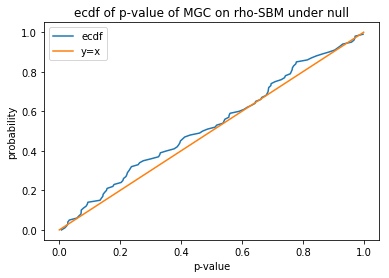

In [3]:
plot_pvalue_ecdf(pvalue_sbm_null, 'ecdf of p-value of MGC on rho-SBM under null')

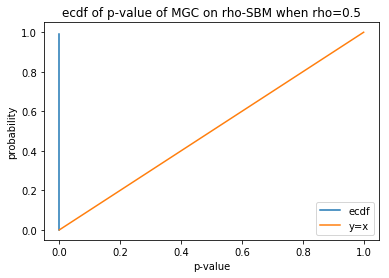

In [4]:
plot_pvalue_ecdf(pvalue_sbm_alt, 'ecdf of p-value of MGC on rho-SBM when rho=0.5')

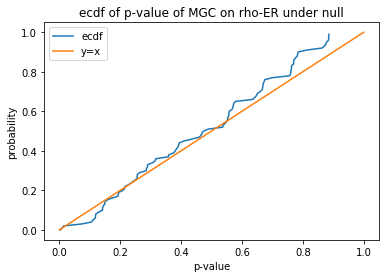

In [5]:
plot_pvalue_ecdf(pvalue_ER_null, 'ecdf of p-value of MGC on rho-ER under null')

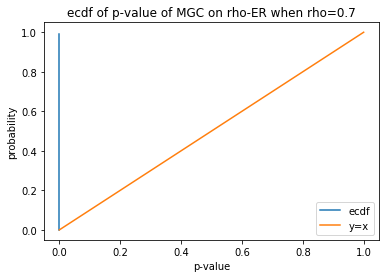

In [7]:
plot_pvalue_ecdf(pvalue_ER_alt, 'ecdf of p-value of MGC on rho-ER when rho=0.7')

In [7]:
def power_n_rho(file_name):
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)
    results_arr = np.zeros((len(outputs), 3))
    for i, op in enumerate(outputs):
        for j, var in enumerate(op):
            if j < 3:
                results_arr[i, j] = var
    return results_arr

Power estimate can be formulated as the estimation of the parameter of a Binomial. Let $X = \sum(I(reject)), n = nmc$, we have $X \sim binomial(n, \beta)$, where power = $\beta$. so $\hat{\beta} = \frac{X}{n}$. <br>

To estimate the variance of $\hat{\beta}$, first write out the $Var(\hat{\beta})$:<br>
$Var(\hat{\beta}) = Var[\frac{1}{n}\sum_{i=1}^n I(reject)] = \frac{1}{n^2}\sum_{i=1}^n Var(I(reject)) = \frac{1}{n^2}\sum \beta(1-\beta) = \frac{\beta(1-\beta)}{n}$<br>

So, the estimated standard deviation of the power estimation is $\hat{\sigma} = \frac{\hat{\beta}(1-\hat{\beta})}{n}$

In [8]:
def power_stddev(power, nmc=500):
    '''
    estimate the standard deviation of the power estimate
    '''
    return np.sqrt(power * (1-power) / nmc )

In [9]:
def power_n_rho_setting(file_name, num_setting):
    '''
    Read power outputs of different rho-SBM settings
    
    Parameters
    ----------
    file_name: string
        the name of the file that stores the power e.g. 'rho_SBM_power_rho_0_0.8_n_10_1000_setting_1_5.pkl'
    num_setting: int
        the number of different SBM settings
        
    Returns
    --------
    results_dict: dict
        key: the SBM setting, string, e.g. 'homog_balanced'
        value: 2d array, each column is [rho, n, power] in such order 
    '''
    with open(file_name, 'rb') as f:
        outputs = pickle.load(f)
    
    results_dict = {}
    for i, op in enumerate(outputs):
        setting = op[3]
        if setting in results_dict:
            for j, var in enumerate(op):
                if j < 3:
                    results_dict[setting][i%(len(outputs)//num_setting), j] = var
        else:
            results_dict[setting] = np.zeros((len(outputs)//num_setting, 3))
            for j, var in enumerate(op):
                if j < 3:
                    results_dict[setting][0, j] = var
    
    return results_dict

In [10]:
all_results = power_n_rho_setting('../data/rho_SBM_power_mgc.pkl', 1)

In [11]:
titles = {'homog_balanced': 'homogeneous balanced rho-SBM(0.7,0.5)',
         'core_peri': 'core peripheral rho-SBM(0.7,0.5)',
         'rank_one': 'rank one rho-SBM(0.49,0.35,0.25)',
         'full_rank': 'full rank rho-SBM(0.7,0.5.0.3)',
         3: '3 block rho-SBM(0.7,0.5)',
         4: '4 block rho-SBM(0.7,0.5)',
         5: '5 block rho-SBM(0.7,0.5)'}

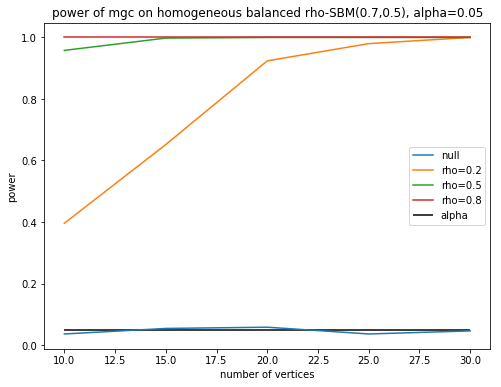

In [12]:
'''
Plot mgc power for different settings of rho-SBM
'''
plt.figure(figsize=(8, 6))

setting = 'homog_balanced'
mgc_results = all_results[setting]
# make sure the number of samples is in order
mgc_results = mgc_results[mgc_results[:, 1].argsort()]
rho_choices = np.unique(mgc_results[:,0])
plt.xlabel('number of vertices')
plt.ylabel('power')
plt.title('power of mgc on {}, alpha=0.05'.format(titles[setting]))

for i, rho in enumerate(rho_choices):
    n = mgc_results[np.where(mgc_results[:,0]==rho)[0], 1]
    mgc_power = mgc_results[np.where(mgc_results[:,0]==rho)[0], 2]
    if rho == -1:
        label = 'null'
    else:
        label = 'rho={}'.format(rho)
    plt.plot(n, mgc_power, label=label)
plt.hlines(y=0.05, xmin=np.amin(mgc_results[:,1]), xmax=np.amax(mgc_results[:,1]), label='alpha')
plt.legend()
plt.show()

In [19]:
setting = 'homog_balanced'
dcorr_results = power_n_rho_setting('../data/rho_SBM_power_dcorr.pkl', 1)[setting]
mgc_results = power_n_rho_setting('../data/rho_SBM_power_mgc.pkl', 1)[setting]
pearson_results = power_n_rho_setting('../data/rho_SBM_power_pearson.pkl', 1)[setting]

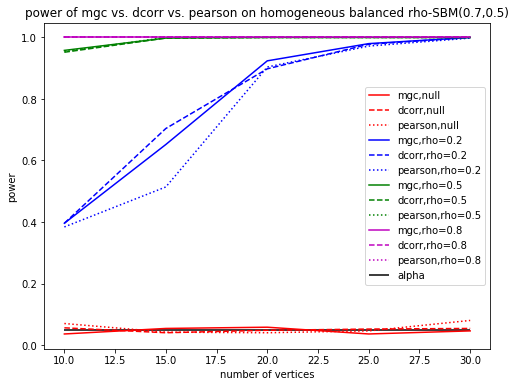

In [25]:
'''
Plot consistency of power of mgc vs. other tests for different settings of rho-SBM
'''
plt.figure(figsize=(8, 6))
rho_choices = np.unique(dcorr_results[:,0])
colors = ['r', 'b', 'g', 'm']
plt.xlabel('number of vertices')
plt.ylabel('power')
plt.title('power of mgc vs. dcorr vs. pearson on {}'.format(titles[setting]))

for i, rho in enumerate(rho_choices):
    n = dcorr_results[np.where(dcorr_results[:,0]==rho)[0], 1]
    mgc_power = mgc_results[np.where(mgc_results[:,0]==rho)[0], 2]
    dcorr_power = dcorr_results[np.where(dcorr_results[:,0]==rho)[0], 2]
    pearson_power = pearson_results[np.where(pearson_results[:,0]==rho)[0], 2]
    if rho == -1:
        label = 'null'
    else:
        label = 'rho={}'.format(rho)
    plt.plot(n, mgc_power, color=colors[i], label='mgc,'+ label)
    plt.plot(n, dcorr_power, color=colors[i], linestyle='dashed', label='dcorr,' + label)
    plt.plot(n, pearson_power, color=colors[i], linestyle='dotted', label='pearson,' + label)

plt.hlines(y=0.05, xmin=np.amin(dcorr_results[:,1]), xmax=np.amax(dcorr_results[:,1]), label='alpha')
plt.legend()
plt.show()

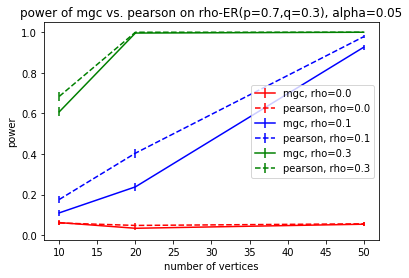

In [34]:
'''
Plot power of mgc vs. pearson on rho-ER
'''

rho_choices = np.unique(mgc_results[:,0])
colors = ['r', 'b', 'g']
plt.xlabel('number of vertices')
plt.ylabel('power')
plt.title('power of mgc vs. pearson on rho-ER(p=0.7,q=0.3), alpha=0.05')

for i, rho in enumerate(rho_choices):
    n = mgc_results[np.where(mgc_results[:,0]==rho)[0], 1]
    mgc_power = mgc_results[np.where(mgc_results[:,0]==rho)[0], 2]
    pearson_power = pearson_results[np.where(pearson_results[:,0]==rho)[0], 2]
    plt.errorbar(n, mgc_power, yerr=power_stddev(mgc_power), color=colors[i], label='mgc, rho={}'.format(rho))
    plt.errorbar(n, pearson_power, yerr=power_stddev(pearson_power), color=colors[i], linestyle='dashed', label='pearson, rho={}'.format(rho))
plt.legend()
plt.savefig('plots/rho_ER_marg_power_mgc_pearson')
plt.show()